In [34]:
import numpy as np
import pywt
import matplotlib.pyplot as plt
import random
from scipy import stats
from scipy import fft
import random
import pywt.data
from PIL import Image
import pandas as pd
import seaborn as sns
import os
import pickle

In [35]:
# assign directory
ROOT_DIR = '/Users/brandonmarks/Desktop/Research Materials/hierarchical-bayesian-model-validation/'
data_dir = ROOT_DIR + 'Data/Panoptic Argiculture 2/Toy dataset - Near Infra Red'
 
# iterate over files in that directory
file_list = [os.path.join(data_dir, filename) for filename in os.listdir(data_dir)]
file_names = os.listdir(data_dir)


In [36]:
def getIndexDF(image):
    x_freqs = fft.fftfreq(image.shape[0])
    y_freqs = fft.fftfreq(image.shape[1])
    coord_df = pd.DataFrame()
    coord_df["index_coords"] = [(x,y) for x in np.arange(image.shape[0]) for y in np.arange(image.shape[0])]
    coord_df["x_index"] = [x for x in np.arange(image.shape[0]) for y in np.arange(image.shape[0])]
    coord_df["y_index"] = [y for x in np.arange(image.shape[0]) for y in np.arange(image.shape[0])]
    coord_df["x_freq"] = [x_freqs[x] for x in np.arange(image.shape[0]) for y in np.arange(image.shape[0])]
    coord_df["y_freq"] = [y_freqs[y] for x in np.arange(image.shape[0]) for y in np.arange(image.shape[0])]
    coord_df["magnitude"] = np.sqrt(coord_df["x_freq"] ** 2 + coord_df["y_freq"] **2)
    coord_df = coord_df.set_index(["index_coords"])
    coord_df = coord_df[(coord_df["x_freq"] >= 0 )& (coord_df["y_freq"] >= 0)]
    return coord_df

In [37]:
def convert_to_fourier_basis(folder_dir, k, grey_scale_only=False):
    file_list = [os.path.join(folder_dir, filename) for filename in os.listdir(folder_dir)]
    file_names = os.listdir(folder_dir)
    
    image = Image.open(file_list[0]).convert('L')
    image = np.array(image)
    coord_df = getIndexDF(image)
    max_mag = max(coord_df["magnitude"].to_numpy())
    cuttoffs = np.linspace(0, max_mag, k+1)
    cuttoffs[-1] += 0.0001
    

    df = pd.DataFrame(columns=["Image ID", "Band", "Channel", "Data"])
    
    coord_arr = []
    for j in range(k):
        filtered = coord_df[(coord_df["magnitude"] >= cuttoffs[j] )&  (coord_df["magnitude"] < cuttoffs[j+1])]
        x = filtered["x_index"].to_numpy()
        y = filtered["y_index"].to_numpy()
        coord_arr.append([tuple(x),tuple(y)])

    if grey_scale_only == True:
            colors_id = [3]
    else:
        colors_id = np.arange(3)
    colors = ["Red", "Green", "Blue", "Gray"]
    #Fill DF DICT


    for i in range(len(file_list)):
        name = file_names[i].split(".")[0]
        for c in colors_id:
            if c == 3:
                image = Image.open(file_list[k]).convert('L')
                
            else:
                image = np.array(Image.open(file_list[k]))[c]
        
            image = np.array(image)
            
            transformed = np.array(fft.fft2(image))
            for j in range(k):
                x_ind,y_ind = coord_arr[j]
                df.loc[len(df.index)] = [name, j+1,colors[c], transformed[y_ind, x_ind]]

        

        
    return df

In [38]:
converted = convert_to_fourier_basis(data_dir, 7, grey_scale_only=True)
converted

,Image ID,Band,Channel,Data
0,1LVU94MUU_4909-9397-5421-9909,1,Gray,"[(17732877-0j), (-31212.458174498654-145850.07..."
1,1LVU94MUU_4909-9397-5421-9909,2,Gray,"[(43292.832984608685-38345.493517273295j), (-5..."
2,1LVU94MUU_4909-9397-5421-9909,3,Gray,"[(-238.50297010158147-3716.2170312996186j), (-..."
3,1LVU94MUU_4909-9397-5421-9909,4,Gray,"[(-3587.6421484111543+2104.947692594838j), (20..."
4,1LVU94MUU_4909-9397-5421-9909,5,Gray,"[(-481.1417235068475+747.407536172459j), (-503..."
...,...,...,...,...
7051,1J1YDIPXC_5940-6746-6452-7258,3,Gray,"[(-238.50297010158147-3716.2170312996186j), (-..."
7052,1J1YDIPXC_5940-6746-6452-7258,4,Gray,"[(-3587.6421484111543+2104.947692594838j), (20..."
7053,1J1YDIPXC_5940-6746-6452-7258,5,Gray,"[(-481.1417235068475+747.407536172459j), (-503..."
7054,1J1YDIPXC_5940-6746-6452-7258,6,Gray,"[(1612.842231483637-1017.648974595355j), (-548..."


Layer 7 = 3256320
Layer 8 = 13025280

In [39]:
n = converted.groupby("Band").size().iloc[0]
converted["Size"] = converted["Data"].apply(lambda x: x.size)
converted["Total Size"] = converted["Size"]*n
test = converted.head(7)
test

,Image ID,Band,Channel,Data,Size,Total Size
0,1LVU94MUU_4909-9397-5421-9909,1,Gray,"[(17732877-0j), (-31212.458174498654-145850.07...",2137,2154096
1,1LVU94MUU_4909-9397-5421-9909,2,Gray,"[(43292.832984608685-38345.493517273295j), (-5...",6302,6352416
2,1LVU94MUU_4909-9397-5421-9909,3,Gray,"[(-238.50297010158147-3716.2170312996186j), (-...",10481,10564848
3,1LVU94MUU_4909-9397-5421-9909,4,Gray,"[(-3587.6421484111543+2104.947692594838j), (20...",14638,14755104
4,1LVU94MUU_4909-9397-5421-9909,5,Gray,"[(-481.1417235068475+747.407536172459j), (-503...",18713,18862704
5,1LVU94MUU_4909-9397-5421-9909,6,Gray,"[(1612.842231483637-1017.648974595355j), (-548...",10364,10446912
6,1LVU94MUU_4909-9397-5421-9909,7,Gray,"[(-183.84597894597323-534.1098811907387j), (-4...",2901,2924208


In [40]:
sum(test["Size"])

65536

In [41]:
band = 1
complex_data = np.concatenate(converted[converted["Band"] == band]["Data"].to_numpy())
real_data = np.real(complex_data)
imag_data = np.imag(complex_data)


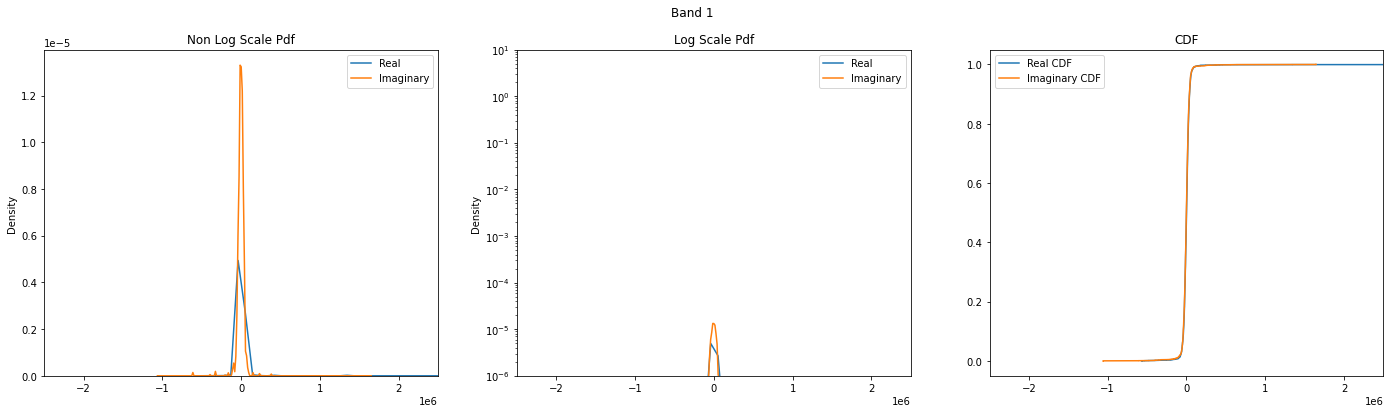

In [42]:
n_r = len(real_data)
n_c = len(imag_data)
bound = 1e7
fig, axes = plt.subplots(1, 3, figsize=(24, 6))
axes[0].set_xlim(left = -.25*bound, right = .25*bound)
axes[1].set_xlim(left = -.25*bound, right = .25*bound)
axes[1].set_ylim(bottom = 10**-6, top= 10)
axes[2].set_xlim(left = -.25*bound, right = .25*bound)
sns.kdeplot(ax = axes[0], x = real_data, bw_method=0.02, label = "Real")
sns.kdeplot(ax = axes[0], x = imag_data,bw_method = 0.02, label = "Imaginary")
sns.kdeplot(ax = axes[1], x = real_data, bw_method = 0.02, log_scale=[False, True], label = "Real")
sns.kdeplot(ax = axes[1], x = imag_data, bw_method = 0.02, log_scale=[False, True], label = "Imaginary")
axes[2].plot(np.sort(real_data), np.arange(1, n_r+1)/n_r, label='Real CDF')
axes[2].plot(np.sort(imag_data), np.arange(1, n_c+1)/n_c, label='Imaginary CDF')
axes[0].set_title("Non Log Scale Pdf")
axes[1].set_title("Log Scale Pdf")
axes[2].set_title("CDF")
fig.suptitle("Band " + str(band))
axes[0].legend()
axes[1].legend()
axes[2].legend()

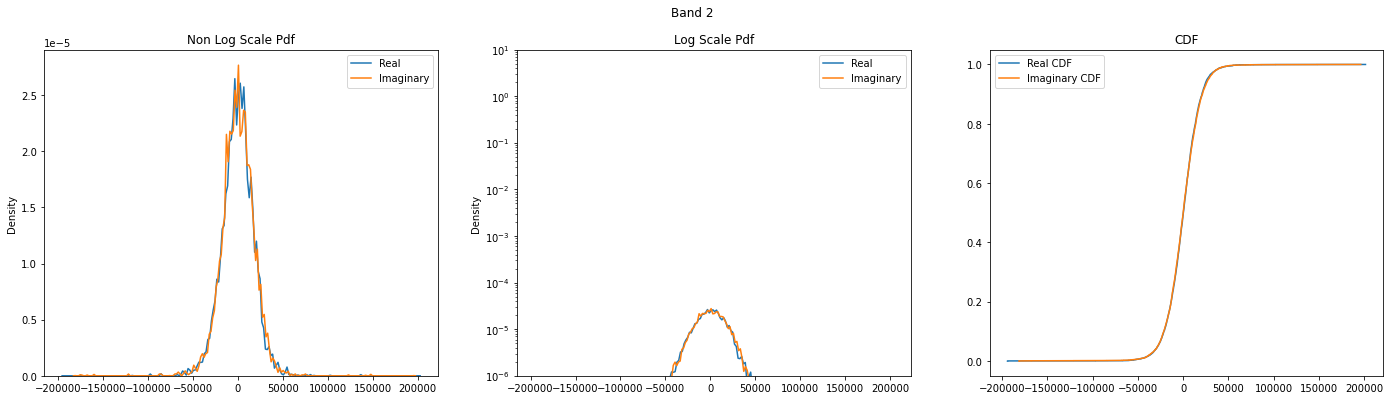

In [43]:
band = 2
complex_data = np.concatenate(converted[converted["Band"] == band]["Data"].to_numpy())
real_data = np.real(complex_data)
imag_data = np.imag(complex_data)


n_r = len(real_data)
n_c = len(imag_data)
bound = 1e7
fig, axes = plt.subplots(1, 3, figsize=(24, 6))
#axes[0].set_xlim(left = -.25*bound, right = .25*bound)
#axes[1].set_xlim(left = -.25*bound, right = .25*bound)
axes[1].set_ylim(bottom = 10**-6, top= 10)
#axes[2].set_xlim(left = -.25*bound, right = .25*bound)
sns.kdeplot(ax = axes[0], x = real_data, bw_method=0.02, label = "Real")
sns.kdeplot(ax = axes[0], x = imag_data,bw_method = 0.02, label = "Imaginary")
sns.kdeplot(ax = axes[1], x = real_data, bw_method = 0.02, log_scale=[False, True], label = "Real")
sns.kdeplot(ax = axes[1], x = imag_data, bw_method = 0.02, log_scale=[False, True], label = "Imaginary")
axes[2].plot(np.sort(real_data), np.arange(1, n_r+1)/n_r, label='Real CDF')
axes[2].plot(np.sort(imag_data), np.arange(1, n_c+1)/n_c, label='Imaginary CDF')
axes[0].set_title("Non Log Scale Pdf")
axes[1].set_title("Log Scale Pdf")
axes[2].set_title("CDF")
fig.suptitle("Band " + str(band))
axes[0].legend()
axes[1].legend()
axes[2].legend()

In [50]:
def ComplexStudy(convertedDF, band, bound = 1e7, bw = 0.02):
    complex_data = np.concatenate(convertedDF[convertedDF["Band"] == band]["Data"].to_numpy())
    real_data = np.real(complex_data)
    imag_data = np.imag(complex_data)


    n_r = len(real_data)
    n_c = len(imag_data)
    fig, axes = plt.subplots(1, 3, figsize=(24, 6))
    #axes[0].set_xlim(left = -.25*bound, right = .25*bound)
    #axes[1].set_xlim(left = -.25*bound, right = .25*bound)
    axes[1].set_ylim(bottom = 10**-6, top= 10)
    #axes[2].set_xlim(left = -.25*bound, right = .25*bound)
    sns.kdeplot(ax = axes[0], x = real_data, bw_method=bw, label = "Real")
    sns.kdeplot(ax = axes[0], x = imag_data,bw_method = bw, label = "Imaginary")
    sns.kdeplot(ax = axes[1], x = real_data, bw_method = bw, log_scale=[False, True], label = "Real")
    sns.kdeplot(ax = axes[1], x = imag_data, bw_method = bw, log_scale=[False, True], label = "Imaginary")
    axes[2].plot(np.sort(real_data), np.arange(1, n_r+1)/n_r, label='Real CDF')
    axes[2].plot(np.sort(imag_data), np.arange(1, n_c+1)/n_c, label='Imaginary CDF')
    axes[0].set_title("Non Log Scale Pdf")
    axes[1].set_title("Log Scale Pdf")
    axes[2].set_title("CDF")
    fig.suptitle("Band " + str(band))
    axes[0].legend()
    axes[1].legend()
    axes[2].legend()

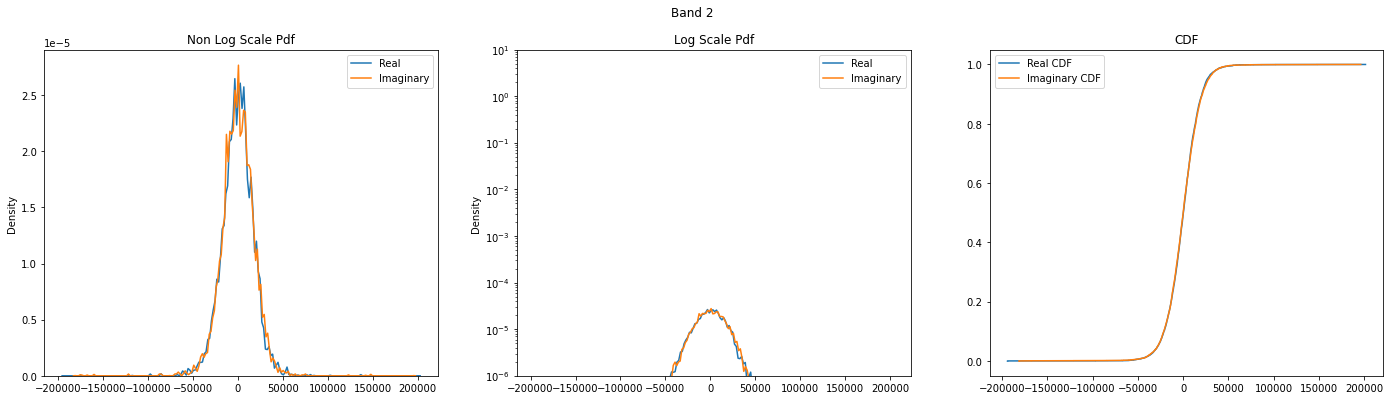

In [51]:
ComplexStudy(converted, 2)

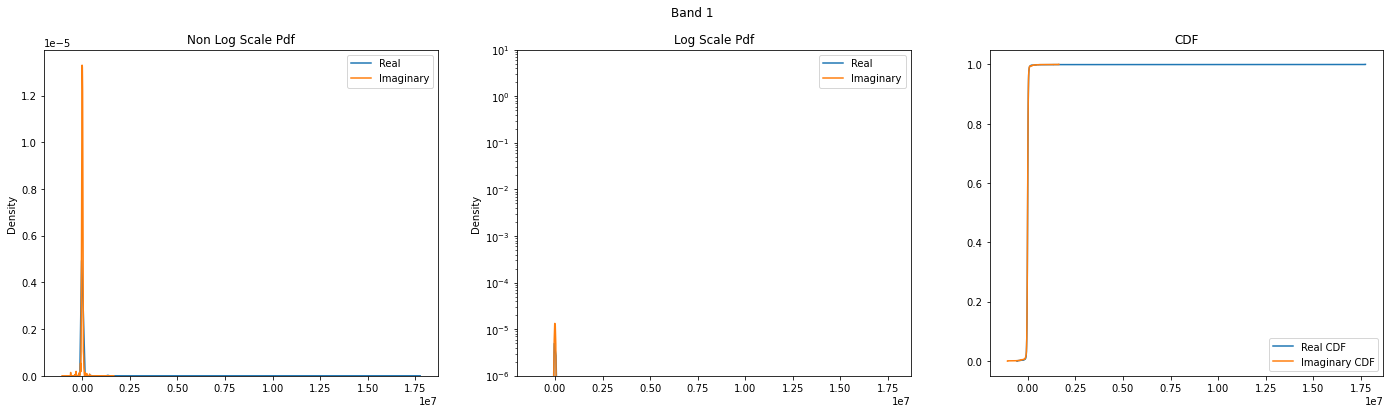

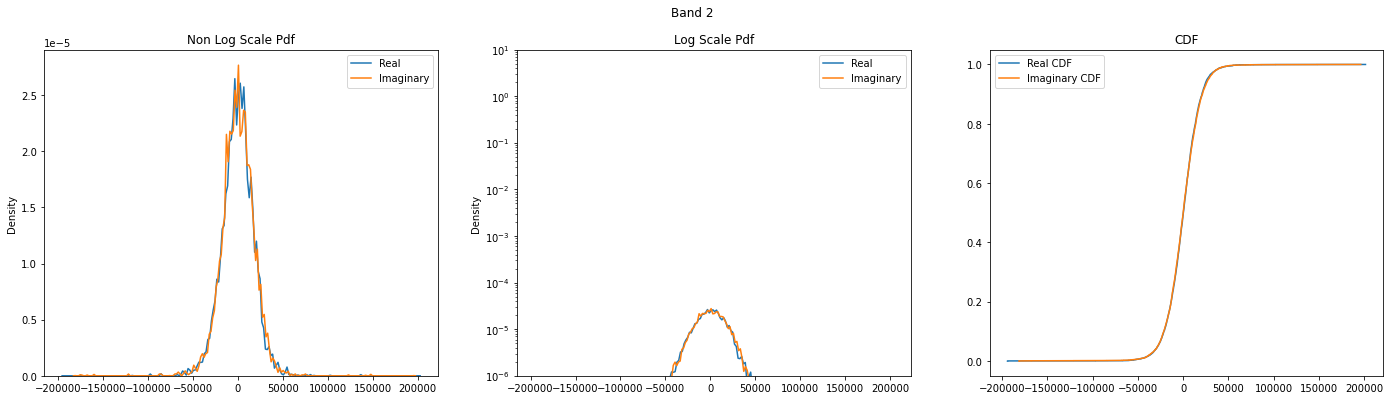

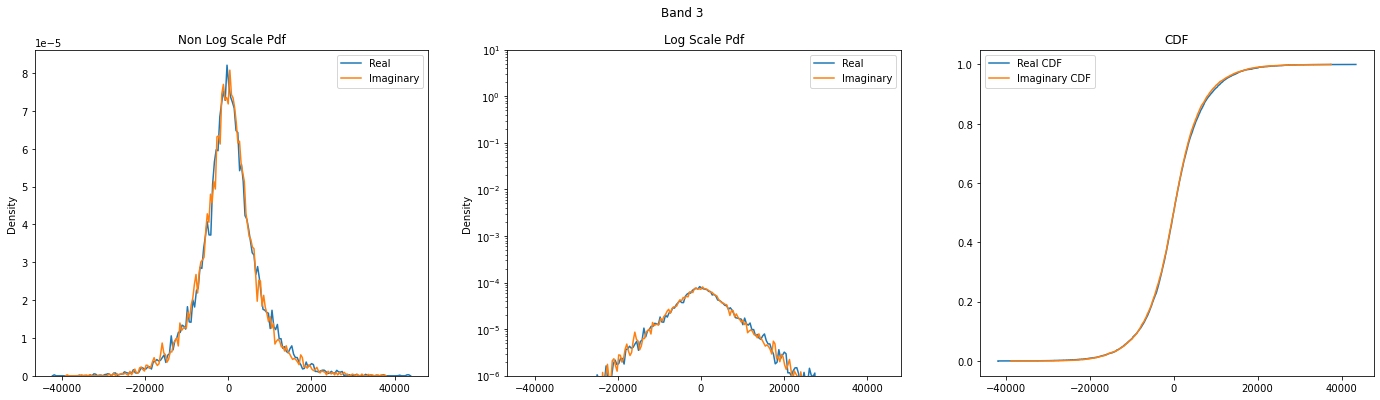

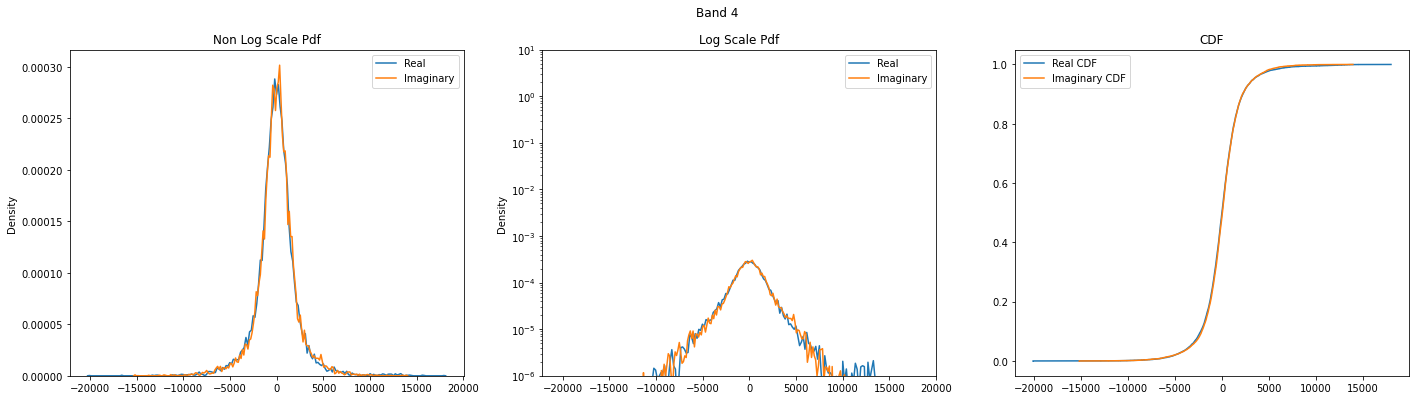

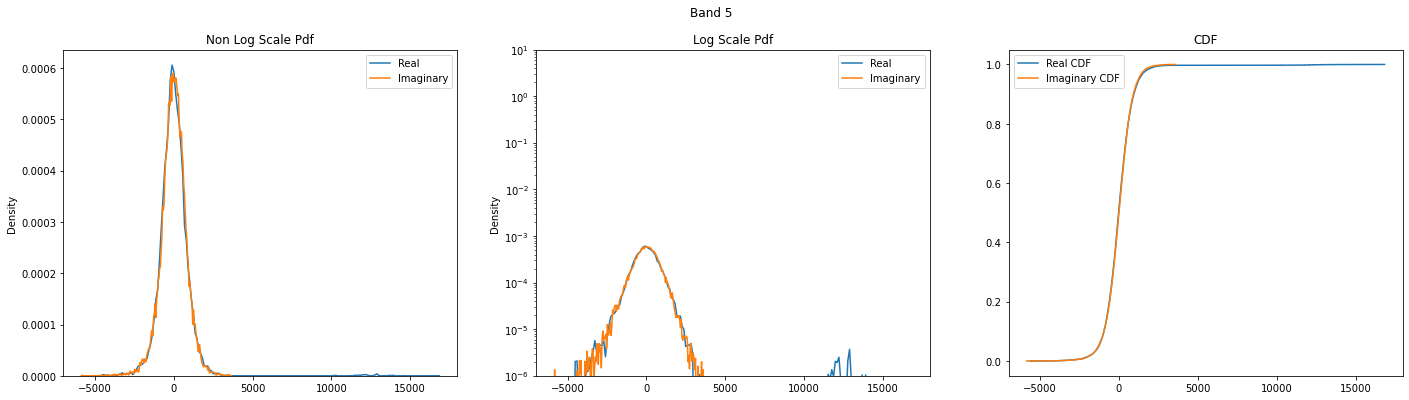

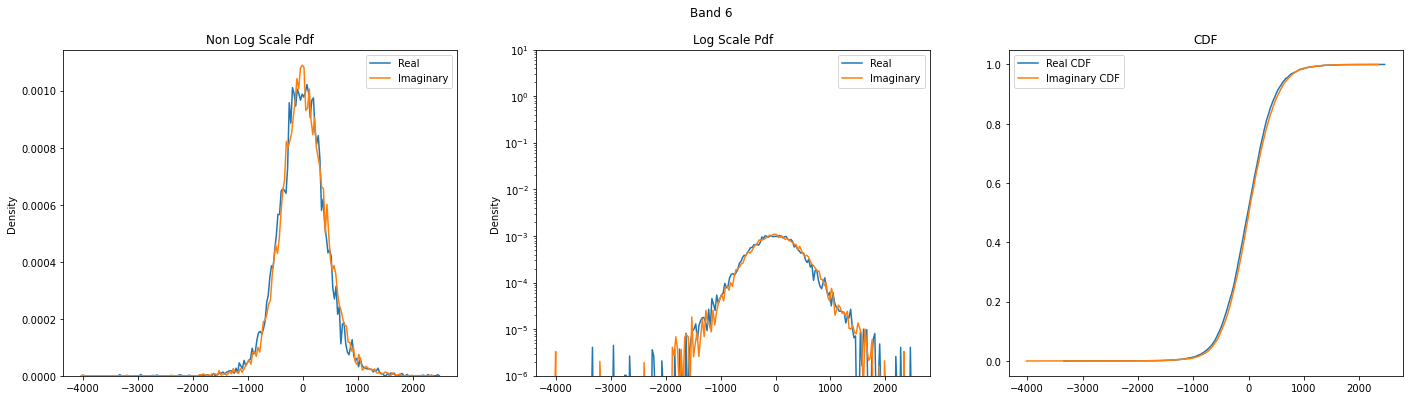

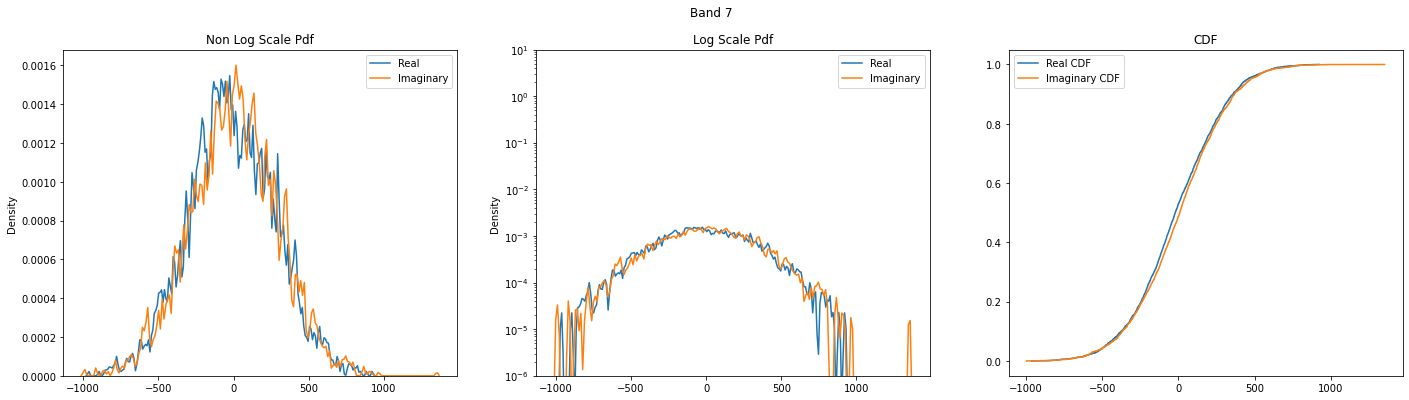

In [52]:
for i in range(1, 8):
    ComplexStudy(converted, i)

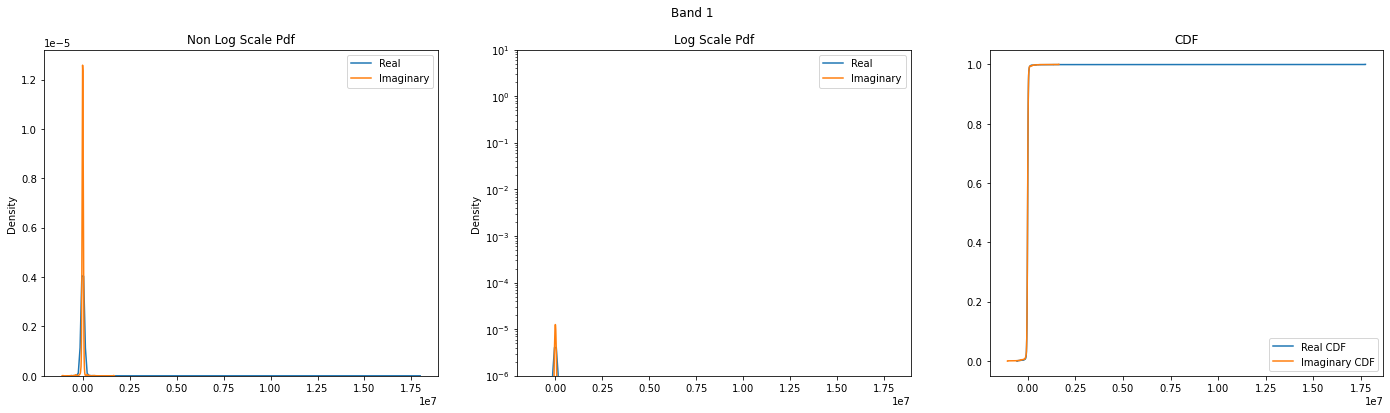

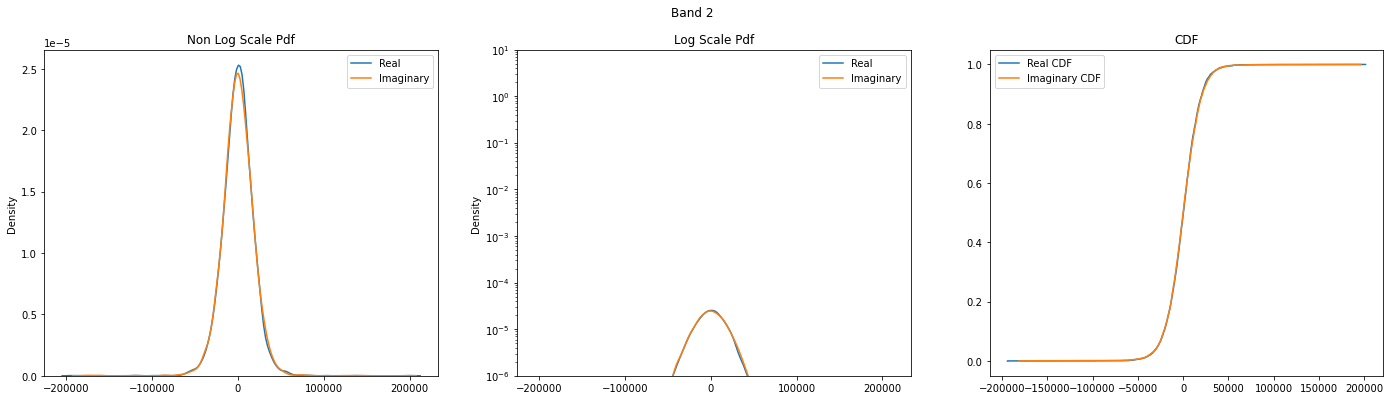

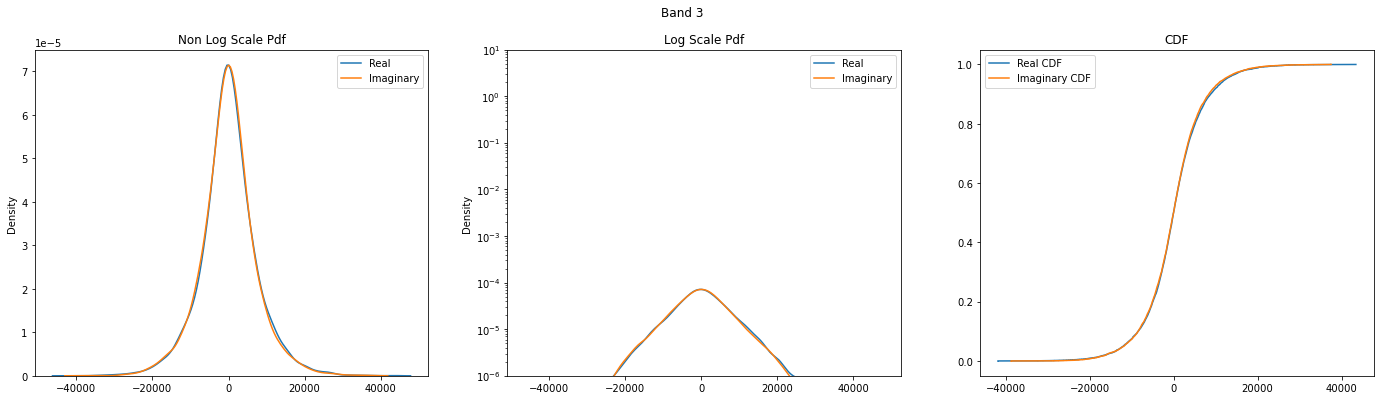

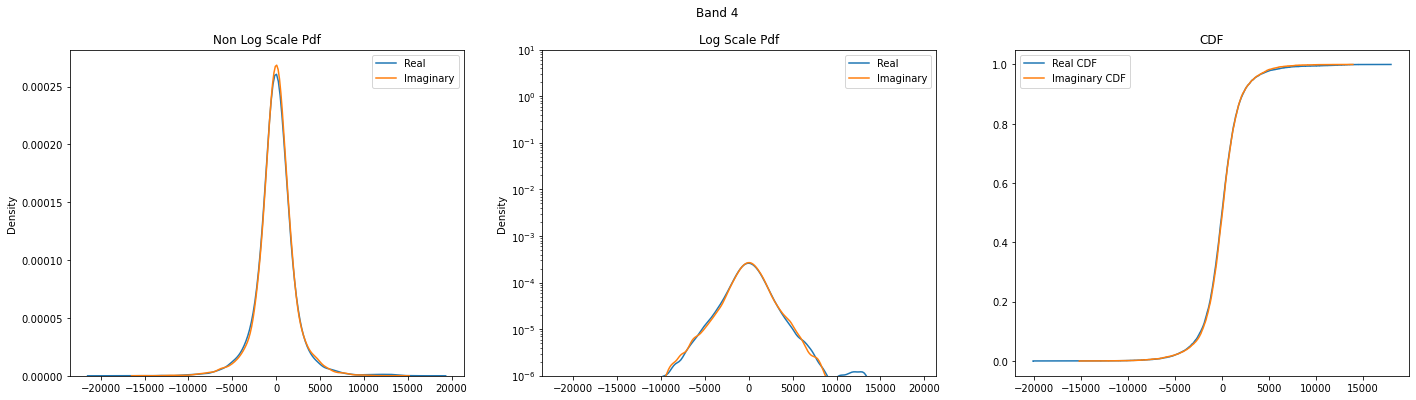

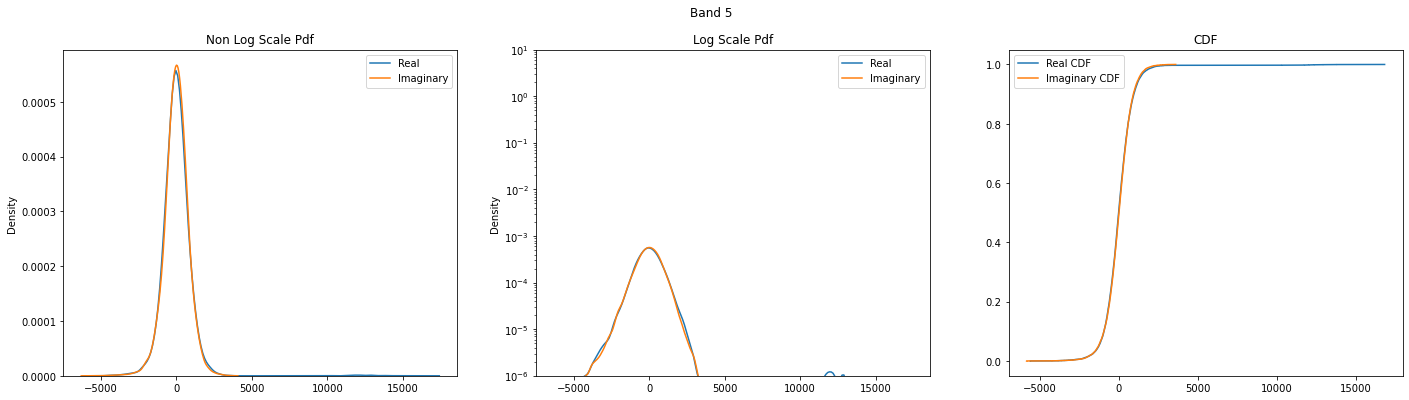

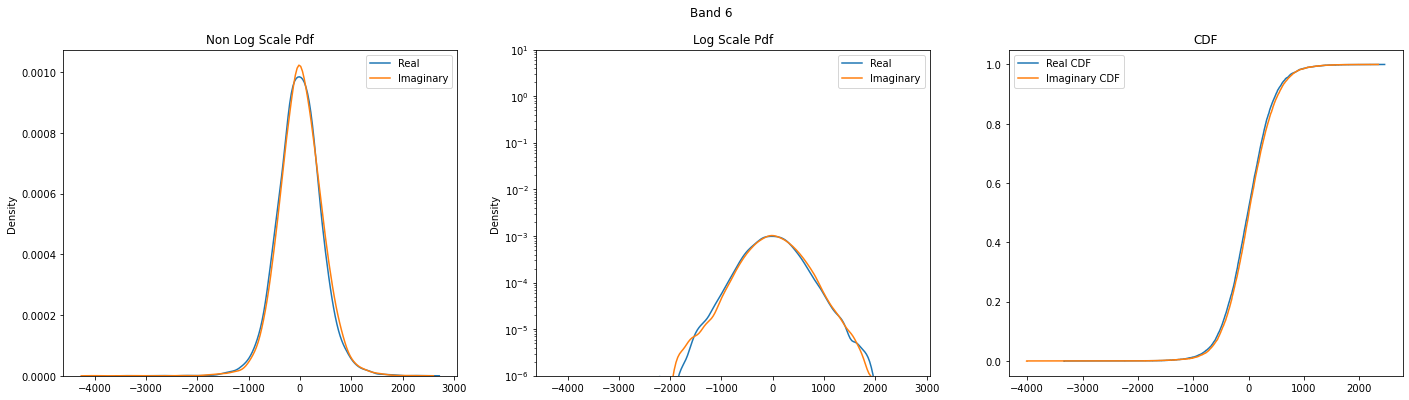

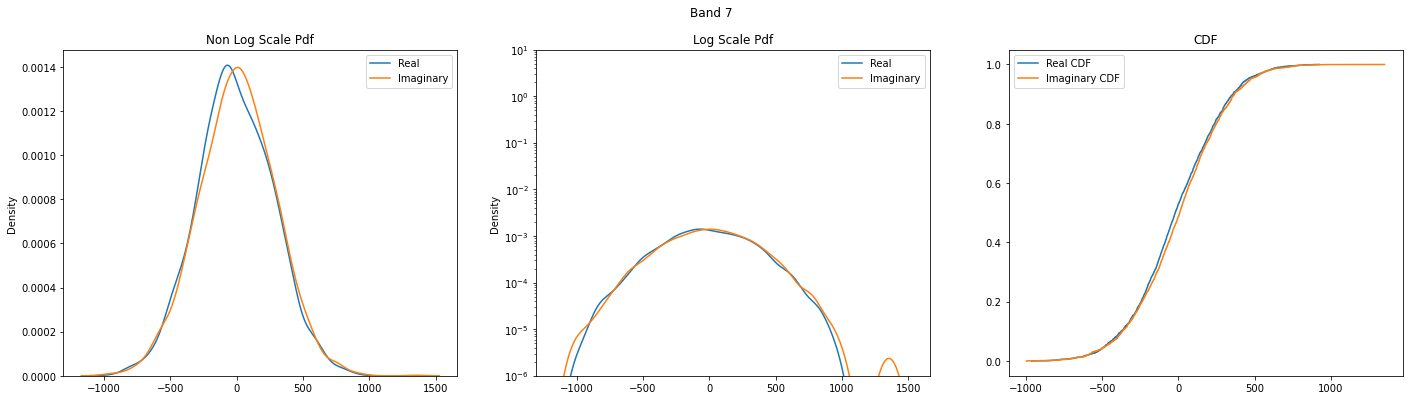

In [53]:
for i in range(1, 8):
    ComplexStudy(converted, i, bw = 0.2)